# Problem 2: Long-Tailed Recognition on Imbalanced Dataset

In the existing visual recognition setting, the training data and testing data are both balanced under a closed-world setting, e.g., the ImageNet dataset. However, this setting is not a good proxy for the real-world scenario. This imbalanced data distribution in the training set may largely degrade the performance of the machine learning or deep learning-based method.

Our goal is to build a CNN model that can accurately classify the images into their respective categories under imbalanced settings.

### Readings before you start

1. Slides from EE443 lecture: 6 CNN Classifiers [[link]](https://canvas.uw.edu/courses/1633421/files/folder/lecture%20notes?preview=105557323)
2. Bag of tricks for long-tailed visual recognition with deep convolutional neural networks [[Paper]](http://www.lamda.nju.edu.cn/zhangys/papers/AAAI_tricks.pdf) [[Github]](https://github.com/zhangyongshun/BagofTricks-LT)

In [ ]:
%matplotlib inline

import csv
import math
import os

import numpy as np
import pandas as pd

from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='pastel')

np.random.seed(443)

## Prepare Imbalanced CIFAR-30 Dataset from CIFAR-*100*

You will be building the imbalanced version of CIFAR-30 from the CIFAR-100:

\begin{equation*}
    \beta = \frac{max(\{n_1, n_2, \cdots, n_k\})}{min(\{n_1, n_2, \cdots, n_k\})}\
\end{equation*}

\noindent where $n_i$ represents the number of images for class $i$. Therefore, the larger the imbalance factor $\beta$ is, the harder it gets for doing long-tailed recognition on such data. With a $\beta=100$ version of CIFAR-100, the head classes will have $500$ training samples while the tail classes only have $5$ training samples.

In [ ]:
# create a custom dataset CIFAR30 from CIFAR100
class CIFAR30(torchvision.datasets.CIFAR100):
    # cifar100 has 100 classes, we only want 30
    cls_num = 30

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False, imbalanced=False):
        super(CIFAR30, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)

        self.remove_extra_class(self.cls_num)

        if self.train and imbalanced:
            img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
            self.gen_imbalanced_data(img_num_list)

        self.update_num_per_cls()

    # remove extra classes to make it 30 classes
    def remove_extra_class(self, cls_num):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        for i in range(cls_num):
            idx = np.where(targets_np == i)[0]
            new_data.append(self.data[idx, ...])
            new_targets.extend([i, ] * len(idx))
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets


    # get the number of images per class we desire
    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    # generate imbalanced data from original dataset with given img_num_per_cls
    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def update_num_per_cls(self):
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for cls in classes:
            self.num_per_cls_dict[cls] = len(np.where(targets_np == cls)[0])

We will also be adapting some extra transorms (augmentations) on our CIFAR-30:

In [ ]:
# transforms for training and testing
training_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=1),
     transforms.RandomAffine(degrees=60),
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
testing_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# create the datasets
cifar30_trainset = CIFAR30(root='./data', train=True, download=True,
                                transform=training_transform, imbalanced=False)
im_cifar30_trainset = CIFAR30(root='./data', train=True, download=True,
                                transform=training_transform, imbalanced=True)
cifar30_testset = CIFAR30(root='./data', train=False, download=True,
                               transform=testing_transform, imbalanced=False)

100%|██████████| 169001437/169001437 [00:01<00:00, 95443408.77it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Compare the data (label) distribution of the three dataset `cifar30_trainset`, `im_cifar30_trainset`, and `cifar30_testset` we constructed:

1. Balanced Training Data
2. Imbalanced Training Data
3. Balanced Testing Data

Text(0.5, 1.0, 'Testing Data')

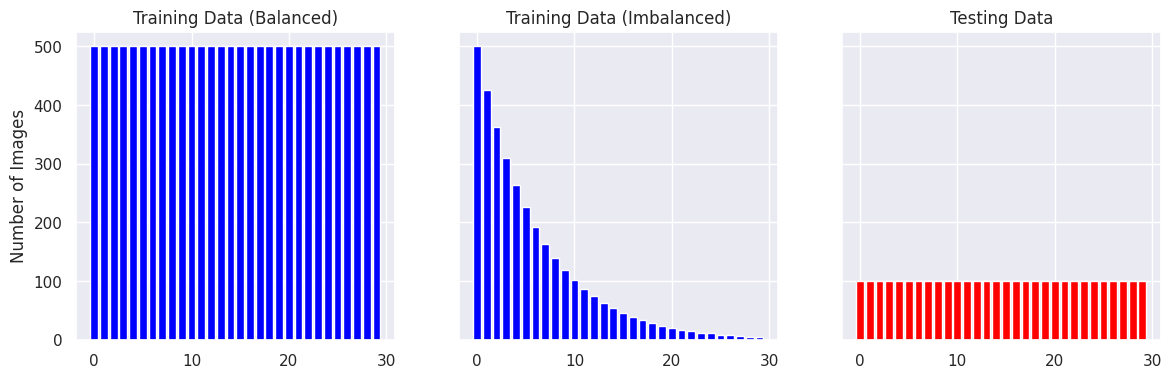

In [ ]:
training_distribution = list(cifar30_trainset.num_per_cls_dict.values())
im_training_distribution = list(im_cifar30_trainset.num_per_cls_dict.values())
testing_distribution = list(cifar30_testset.num_per_cls_dict.values())
training_cls = list(im_cifar30_trainset.num_per_cls_dict.keys())

plt.subplots(1, 3, sharey=True, figsize=(14,4))

plt.subplot(1, 3, 1)
plt.bar(training_cls, training_distribution, color='blue')
plt.title('Training Data (Balanced)')
plt.ylabel('Number of Images')
plt.subplot(1, 3, 2)
plt.bar(training_cls, im_training_distribution, color='blue')
plt.title('Training Data (Imbalanced)')
plt.subplot(1, 3, 3)
plt.bar(training_cls, testing_distribution, color='red')
plt.title('Testing Data')

Show some images with labels (class names) from dataset.

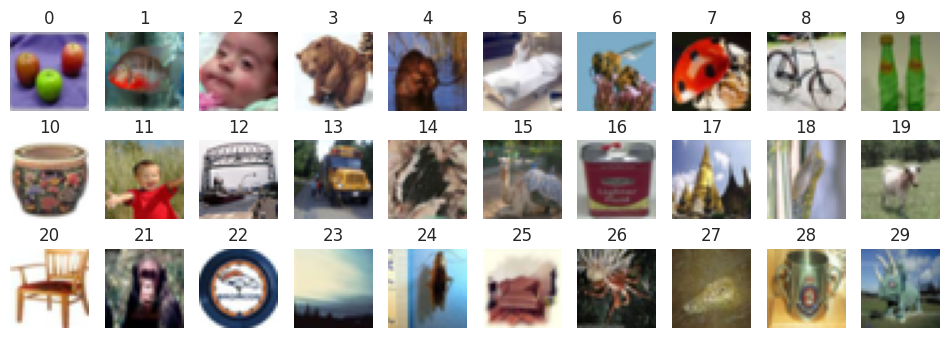

In [ ]:
def cifar_imshow(img):
  img = img / 2 + 0.5 # unnormalize the image
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0)) # reorganize the channel

# visualize some samples in the CIFAR-30 dataset
fig, axs = plt.subplots(3, 10, figsize = (12, 4))

# loop through subplots and images
for i, ax in enumerate(axs.flat):
  ax.imshow(cifar_imshow(cifar30_testset[i*100][0]))
  ax.axis('off')
  ax.set_title('{}'.format(cifar30_testset[i*100][1]))

## 2-a. Train CNN Baseline

Check whether your runtime is on GPU or not.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
!nvidia-smi

Using device: cuda:0
Thu May 11 03:02:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                   

The CNN we will be using in this problem is called ResNet:



In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=30):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

my_cnn = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

## Trainer and Tester code

In [ ]:
def trainer(train_loader, valid_loader, model, config, device, weight=None):

    criterion = nn.CrossEntropyLoss(reduction='mean', weight=weight)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7) 

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        # writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        val_accuracy = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

                _, predicted = torch.max(pred.data, 1)
                val_accuracy.append((predicted == y).sum().item() / predicted.size(0))
            loss_record.append(loss.item())
        print('Accuracy:', sum(val_accuracy)/len(val_accuracy))
    
    torch.save(model.state_dict(), config['save_path'])

def tester(test_loader, model, config, device):

    model.eval() # Set your model to evaluation mode.
    loss_record = []
    test_accuracy = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            _, predicted = torch.max(pred.data, 1)
            test_accuracy.append((predicted == y).sum().item() / predicted.size(0))
    print(sum(test_accuracy)/len(test_accuracy))

## Sample Config Dict

In [ ]:
config = {
    'seed': 1968990,      # Your seed number, you can pick your lucky number. :)
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 50,      # Number of epochs.            
    'batch_size': 32, 
    'learning_rate': 0.01,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/baseline_model.ckpt'  # Your model will be saved here.
}

## Prepare the Dataloader 

In [ ]:
# Original CIFAR-30
cifar30_train_data, cifar30_valid_data = random_split(cifar30_trainset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(cifar30_train_data, batch_size=config['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(cifar30_valid_data, batch_size=config['batch_size'], shuffle=True)

# Imbalanced CIFAR-30
im_cifar30_train_data, im_cifar30_valid_data = random_split(im_cifar30_trainset, [0.8, 0.2])

im_train_loader = torch.utils.data.DataLoader(im_cifar30_train_data, batch_size=config['batch_size'], shuffle=True)
im_valid_loader = torch.utils.data.DataLoader(im_cifar30_valid_data, batch_size=config['batch_size'], shuffle=True)

# CIFAR-30 Testing (always balanced)
test_loader = torch.utils.data.DataLoader(cifar30_testset, batch_size=config['batch_size'], shuffle=False)

### Train on original CIFAR-30

In [ ]:
trainer(im_train_loader,  im_valid_loader, my_cnn, config, device)

Epoch [1/50]: 100%|██████████| 85/85 [00:15<00:00,  5.43it/s, loss=1.65]


Accuracy: 0.30952380952380953


Epoch [2/50]: 100%|██████████| 85/85 [00:07<00:00, 11.09it/s, loss=1.58]


Accuracy: 0.37351190476190477


Epoch [3/50]: 100%|██████████| 85/85 [00:06<00:00, 12.79it/s, loss=1.06]


Accuracy: 0.3645833333333333


Epoch [4/50]: 100%|██████████| 85/85 [00:06<00:00, 12.69it/s, loss=2.58]


Accuracy: 0.3392857142857143


Epoch [5/50]: 100%|██████████| 85/85 [00:07<00:00, 11.85it/s, loss=0.57]


Accuracy: 0.37648809523809523


Epoch [6/50]: 100%|██████████| 85/85 [00:06<00:00, 13.02it/s, loss=1.86]


Accuracy: 0.3645833333333333


Epoch [7/50]: 100%|██████████| 85/85 [00:06<00:00, 12.32it/s, loss=2.1]


Accuracy: 0.35267857142857145


Epoch [8/50]: 100%|██████████| 85/85 [00:07<00:00, 11.71it/s, loss=3.06]


Accuracy: 0.45535714285714285


Epoch [9/50]: 100%|██████████| 85/85 [00:06<00:00, 13.10it/s, loss=3.11]


Accuracy: 0.3869047619047619


Epoch [10/50]: 100%|██████████| 85/85 [00:07<00:00, 11.79it/s, loss=3.08]


Accuracy: 0.4330357142857143


Epoch [11/50]: 100%|██████████| 85/85 [00:06<00:00, 12.43it/s, loss=1.8]


Accuracy: 0.4255952380952381


Epoch [12/50]: 100%|██████████| 85/85 [00:06<00:00, 12.89it/s, loss=3.22]


Accuracy: 0.42410714285714285


Epoch [13/50]: 100%|██████████| 85/85 [00:07<00:00, 11.72it/s, loss=2.26]


Accuracy: 0.4642857142857143


Epoch [14/50]: 100%|██████████| 85/85 [00:06<00:00, 12.41it/s, loss=2.8]


Accuracy: 0.47619047619047616


Epoch [15/50]: 100%|██████████| 85/85 [00:06<00:00, 12.61it/s, loss=2.07]


Accuracy: 0.4851190476190476


Epoch [16/50]: 100%|██████████| 85/85 [00:07<00:00, 11.84it/s, loss=2.99]


Accuracy: 0.4583333333333333


Epoch [17/50]: 100%|██████████| 85/85 [00:06<00:00, 13.10it/s, loss=1.07]


Accuracy: 0.39285714285714285


Epoch [18/50]: 100%|██████████| 85/85 [00:06<00:00, 12.32it/s, loss=2.12]


Accuracy: 0.4375


Epoch [19/50]: 100%|██████████| 85/85 [00:07<00:00, 11.90it/s, loss=1.77]


Accuracy: 0.43601190476190477


Epoch [20/50]: 100%|██████████| 85/85 [00:06<00:00, 12.88it/s, loss=3.19]


Accuracy: 0.4226190476190476


Epoch [21/50]: 100%|██████████| 85/85 [00:07<00:00, 11.88it/s, loss=0.53]


Accuracy: 0.5267857142857143


Epoch [22/50]: 100%|██████████| 85/85 [00:07<00:00, 12.07it/s, loss=1.45]


Accuracy: 0.46577380952380953


Epoch [23/50]: 100%|██████████| 85/85 [00:06<00:00, 12.69it/s, loss=0.405]


Accuracy: 0.5148809523809523


Epoch [24/50]: 100%|██████████| 85/85 [00:07<00:00, 12.00it/s, loss=0.704]


Accuracy: 0.5297619047619048


Epoch [25/50]: 100%|██████████| 85/85 [00:06<00:00, 12.72it/s, loss=4.31]


Accuracy: 0.37202380952380953


Epoch [26/50]: 100%|██████████| 85/85 [00:06<00:00, 12.76it/s, loss=2.25]


Accuracy: 0.4523809523809524


Epoch [27/50]: 100%|██████████| 85/85 [00:06<00:00, 12.15it/s, loss=3.46]


Accuracy: 0.45982142857142855


Epoch [28/50]: 100%|██████████| 85/85 [00:06<00:00, 12.97it/s, loss=0.955]


Accuracy: 0.5282738095238095


Epoch [29/50]: 100%|██████████| 85/85 [00:07<00:00, 12.06it/s, loss=1.65]


Accuracy: 0.49404761904761907


Epoch [30/50]: 100%|██████████| 85/85 [00:06<00:00, 12.15it/s, loss=0.92]


Accuracy: 0.49851190476190477


Epoch [31/50]: 100%|██████████| 85/85 [00:06<00:00, 12.80it/s, loss=3.15]


Accuracy: 0.5193452380952381


Epoch [32/50]: 100%|██████████| 85/85 [00:07<00:00, 11.80it/s, loss=2.67]


Accuracy: 0.45982142857142855


Epoch [33/50]: 100%|██████████| 85/85 [00:06<00:00, 12.14it/s, loss=1.26]


Accuracy: 0.5059523809523809


Epoch [34/50]: 100%|██████████| 85/85 [00:06<00:00, 12.75it/s, loss=1.63]


Accuracy: 0.46577380952380953


Epoch [35/50]: 100%|██████████| 85/85 [00:07<00:00, 12.10it/s, loss=3.07]


Accuracy: 0.3333333333333333


Epoch [36/50]: 100%|██████████| 85/85 [00:06<00:00, 12.44it/s, loss=2.14]


Accuracy: 0.46130952380952384


Epoch [37/50]: 100%|██████████| 85/85 [00:06<00:00, 12.78it/s, loss=4.79]


Accuracy: 0.5223214285714286


Epoch [38/50]: 100%|██████████| 85/85 [00:07<00:00, 11.64it/s, loss=3.41]


Accuracy: 0.5148809523809523


Epoch [39/50]: 100%|██████████| 85/85 [00:06<00:00, 12.93it/s, loss=1.98]


Accuracy: 0.49255952380952384


Epoch [40/50]: 100%|██████████| 85/85 [00:06<00:00, 12.35it/s, loss=1.77]


Accuracy: 0.5133928571428571


Epoch [41/50]: 100%|██████████| 85/85 [00:07<00:00, 12.07it/s, loss=0.483]


Accuracy: 0.5327380952380952


Epoch [42/50]: 100%|██████████| 85/85 [00:06<00:00, 12.84it/s, loss=0.586]


Accuracy: 0.5401785714285714


Epoch [43/50]: 100%|██████████| 85/85 [00:07<00:00, 12.06it/s, loss=2.48]


Accuracy: 0.5401785714285714


Epoch [44/50]: 100%|██████████| 85/85 [00:07<00:00, 12.09it/s, loss=0.549]


Accuracy: 0.5461309523809523


Epoch [45/50]: 100%|██████████| 85/85 [00:06<00:00, 12.69it/s, loss=2.1]


Accuracy: 0.5


Epoch [46/50]: 100%|██████████| 85/85 [00:07<00:00, 12.01it/s, loss=0.314]


Accuracy: 0.5595238095238095


Epoch [47/50]: 100%|██████████| 85/85 [00:06<00:00, 12.54it/s, loss=1.8]


Accuracy: 0.4226190476190476


Epoch [48/50]: 100%|██████████| 85/85 [00:06<00:00, 12.55it/s, loss=0.886]


Accuracy: 0.5089285714285714


Epoch [49/50]: 100%|██████████| 85/85 [00:06<00:00, 12.16it/s, loss=1.59]


Accuracy: 0.49851190476190477


Epoch [50/50]: 100%|██████████| 85/85 [00:06<00:00, 12.98it/s, loss=2.12]


Accuracy: 0.4806547619047619


In [ ]:
tester(test_loader, my_cnn, config, device)

0.3191489361702128


## 2-b. Implement Re-Weighting

Hint: 

Notice there is a "weight" argument for the loss we use:

```
criterion = nn.CrossEntropyLoss(reduction='mean', weight=weight)
```


In [ ]:
# Please do not modify the config
re_weighting_config = {
    'seed': 1968990,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 50,      # Number of epochs.            
    'batch_size': 32, 
    'learning_rate': 0.001,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/augmentation_model.ckpt'  # Your model will be saved here.
}

# TODO
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

"""
Different implementations
cost_sensitive = torch.div(torch.min(class_counts),class_counts)
class_balanced = torch.mul(torch.div((1.0-beta), (1.0 - torch.pow(beta, class_counts))))
"""
im_train_loader = DataLoader(im_cifar30_trainset, batch_size=augmentation_config['batch_size'], shuffle=True)
im_valid_loader = DataLoader(cifar30_testset, batch_size=augmentation_config['batch_size'], shuffle=False)

my_cnn_re_weighting = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
trainer(im_train_loader, im_valid_loader, my_cnn_re_weighting, re_weighting_config, device)

# ENDS HERE


Epoch [1/50]: 100%|██████████| 469/469 [00:26<00:00, 18.04it/s, loss=2.95]


Accuracy: 0.265625


Epoch [2/50]: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s, loss=2.13]


Accuracy: 0.32945478723404253


Epoch [3/50]: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s, loss=2.46]


Accuracy: 0.38419769503546103


Epoch [4/50]: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s, loss=2.31]


Accuracy: 0.4093528368794326


Epoch [5/50]: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s, loss=2.53]


Accuracy: 0.47041223404255317


Epoch [6/50]: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s, loss=1.52]


Accuracy: 0.4988918439716312


Epoch [7/50]: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s, loss=1.78]


Accuracy: 0.5279255319148937


Epoch [8/50]: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s, loss=1.28]


Accuracy: 0.5423315602836879


Epoch [9/50]: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s, loss=1.19]


Accuracy: 0.5707003546099291


Epoch [10/50]: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s, loss=1.75]


Accuracy: 0.59197695035461


Epoch [11/50]: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s, loss=1.09]


Accuracy: 0.603945035460993


Epoch [12/50]: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s, loss=1.34]


Accuracy: 0.633311170212766


Epoch [13/50]: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s, loss=1.4]


Accuracy: 0.6145833333333334


Epoch [14/50]: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s, loss=1.4]


Accuracy: 0.636968085106383


Epoch [15/50]: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s, loss=1.19]


Accuracy: 0.6308732269503546


Epoch [16/50]: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s, loss=1.01]


Accuracy: 0.6518173758865249


Epoch [17/50]: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s, loss=0.995]


Accuracy: 0.6716533687943262


Epoch [18/50]: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s, loss=0.687]


Accuracy: 0.6675531914893617


Epoch [19/50]: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s, loss=0.919]


Accuracy: 0.6642287234042553


Epoch [20/50]: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s, loss=0.647]


Accuracy: 0.6827349290780141


Epoch [21/50]: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s, loss=0.668]


Accuracy: 0.6669991134751773


Epoch [22/50]: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s, loss=0.417]


Accuracy: 0.6869459219858156


Epoch [23/50]: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s, loss=0.736]


Accuracy: 0.6978058510638298


Epoch [24/50]: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s, loss=0.707]


Accuracy: 0.6937056737588652


Epoch [25/50]: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s, loss=0.686]


Accuracy: 0.6678856382978723


Epoch [26/50]: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s, loss=0.333]


Accuracy: 0.6870567375886524


Epoch [27/50]: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s, loss=0.295]


Accuracy: 0.6972517730496455


Epoch [28/50]: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s, loss=0.716]


Accuracy: 0.6809618794326242


Epoch [29/50]: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s, loss=0.384]


Accuracy: 0.6811835106382979


Epoch [30/50]: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s, loss=0.453]


Accuracy: 0.7130984042553191


Epoch [31/50]: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s, loss=0.548]


Accuracy: 0.7153147163120567


Epoch [32/50]: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s, loss=0.64]


Accuracy: 0.7152039007092199


Epoch [33/50]: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s, loss=0.697]


Accuracy: 0.7109929078014184


Epoch [34/50]: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s, loss=0.285]


Accuracy: 0.7154255319148937


Epoch [35/50]: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s, loss=0.423]


Accuracy: 0.7220744680851063


Epoch [36/50]: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s, loss=0.409]


Accuracy: 0.7200797872340425


Epoch [37/50]: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s, loss=0.35]


Accuracy: 0.7299423758865248


Epoch [38/50]: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s, loss=0.518]


Accuracy: 0.709552304964539


Epoch [39/50]: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s, loss=0.498]


Accuracy: 0.6957003546099291


Epoch [40/50]: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s, loss=0.266]


Accuracy: 0.7278368794326242


Epoch [41/50]: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s, loss=0.222]


Accuracy: 0.7208554964539008


Epoch [42/50]: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s, loss=0.418]


Accuracy: 0.7220744680851063


Epoch [43/50]: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s, loss=0.263]


Accuracy: 0.7332668439716311


Epoch [44/50]: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s, loss=0.234]


Accuracy: 0.7497783687943262


Epoch [45/50]: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s, loss=0.384]


Accuracy: 0.7289450354609929


Epoch [46/50]: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s, loss=0.163]


Accuracy: 0.7410239361702128


Epoch [47/50]: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s, loss=0.17]


Accuracy: 0.7370345744680851


Epoch [48/50]: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s, loss=0.415]


Accuracy: 0.7419104609929078


Epoch [49/50]: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s, loss=0.228]


Accuracy: 0.746343085106383


Epoch [50/50]: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s, loss=0.376]


Accuracy: 0.7442375886524822


## 2-c. Evaluate Re-Weighting 

In [ ]:
tester(test_loader, my_cnn_re_weighting, re_weighting_config, device)

0.7442375886524822


## 2-d. Implement Re-Sampling

Hint: 

Check out how sampler works in PyTorch's DataLoader!


```
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(class_counts) * 500)
rs_train_loader = DataLoader(im_cifar30_trainset, batch_size=config['batch_size'], sampler=sampler)

```



In [ ]:
# Please do not modify the config
config = {
    'seed': 1968990,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 50,      # Number of epochs.            
    'batch_size': 8, 
    'learning_rate': 0.001,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/re_sampling_model.ckpt'  # Your model will be saved here.
}


# TODO
class_counts = torch.tensor(im_training_distribution)
sample_weights = torch.zeros(len(im_cifar30_trainset))
for i in range(len(im_cifar30_trainset)):
  current_class = im_cifar30_trainset[i][1]
  if class_counts[current_class] > 0:
    sample_weights[i] = 1.0/class_counts[current_class]
sample_weights = sample_weights.to(device)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=sample_weights, num_samples=len(im_cifar30_trainset))
rs_train_loader = DataLoader(im_cifar30_trainset, batch_size=config['batch_size'], sampler=sampler)

# ENDS HERE

In [ ]:
my_cnn_rs = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
trainer(rs_train_loader, test_loader, my_cnn_rs, config, device, weight = class_weights)

Epoch [1/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.02it/s, loss=1.51]


Accuracy: 0.08244680851063829


Epoch [2/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.65it/s, loss=0.649]


Accuracy: 0.13364361702127658


Epoch [3/50]: 100%|██████████| 1500/1500 [00:43<00:00, 34.82it/s, loss=1.24]


Accuracy: 0.13763297872340424


Epoch [4/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.35it/s, loss=0.41]


Accuracy: 0.13164893617021275


Epoch [5/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.57it/s, loss=0.68]


Accuracy: 0.17154255319148937


Epoch [6/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.76it/s, loss=0.467]


Accuracy: 0.14029255319148937


Epoch [7/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.48it/s, loss=0.367]


Accuracy: 0.17287234042553193


Epoch [8/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.60it/s, loss=0.1]


Accuracy: 0.1589095744680851


Epoch [9/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.69it/s, loss=0.156]


Accuracy: 0.13065159574468085


Epoch [10/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.31it/s, loss=0.447]


Accuracy: 0.20345744680851063


Epoch [11/50]: 100%|██████████| 1500/1500 [00:43<00:00, 34.10it/s, loss=0.514]


Accuracy: 0.1934840425531915


Epoch [12/50]: 100%|██████████| 1500/1500 [00:42<00:00, 35.18it/s, loss=0.253]


Accuracy: 0.2160904255319149


Epoch [13/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.75it/s, loss=0.0538]


Accuracy: 0.21143617021276595


Epoch [14/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.85it/s, loss=0.479]


Accuracy: 0.20179521276595744


Epoch [15/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.83it/s, loss=0.0283]


Accuracy: 0.21875


Epoch [16/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.84it/s, loss=0.0115]


Accuracy: 0.19547872340425532


Epoch [17/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.59it/s, loss=0.0423]


Accuracy: 0.21742021276595744


Epoch [18/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.26it/s, loss=0.297]


Accuracy: 0.21409574468085107


Epoch [19/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.56it/s, loss=0.0186]


Accuracy: 0.18351063829787234


Epoch [20/50]: 100%|██████████| 1500/1500 [00:40<00:00, 37.03it/s, loss=0.123]


Accuracy: 0.2160904255319149


Epoch [21/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.83it/s, loss=0.0657]


Accuracy: 0.21775265957446807


Epoch [22/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.35it/s, loss=0.187]


Accuracy: 0.20678191489361702


Epoch [23/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.67it/s, loss=0.156]


Accuracy: 0.23803191489361702


Epoch [24/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.65it/s, loss=0.00654]


Accuracy: 0.22074468085106383


Epoch [25/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.69it/s, loss=0.0355]


Accuracy: 0.2081117021276596


Epoch [26/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.18it/s, loss=0.521]


Accuracy: 0.2310505319148936


Epoch [27/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.96it/s, loss=0.00115]


Accuracy: 0.1988031914893617


Epoch [28/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.50it/s, loss=0.00267]


Accuracy: 0.20678191489361702


Epoch [29/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.74it/s, loss=0.0229]


Accuracy: 0.22273936170212766


Epoch [30/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.53it/s, loss=0.0164]


Accuracy: 0.20877659574468085


Epoch [31/50]: 100%|██████████| 1500/1500 [00:41<00:00, 35.95it/s, loss=0.603]


Accuracy: 0.2473404255319149


Epoch [32/50]: 100%|██████████| 1500/1500 [00:41<00:00, 35.96it/s, loss=0.0975]


Accuracy: 0.23238031914893617


Epoch [33/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.10it/s, loss=0.00419]


Accuracy: 0.2220744680851064


Epoch [34/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.18it/s, loss=0.00888]


Accuracy: 0.2327127659574468


Epoch [35/50]: 100%|██████████| 1500/1500 [00:41<00:00, 35.99it/s, loss=0.00712]


Accuracy: 0.21875


Epoch [36/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.37it/s, loss=0.00143]


Accuracy: 0.25


Epoch [37/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.71it/s, loss=0.176]


Accuracy: 0.2376994680851064


Epoch [38/50]: 100%|██████████| 1500/1500 [00:40<00:00, 36.89it/s, loss=0.0553]


Accuracy: 0.2091090425531915


Epoch [39/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.58it/s, loss=0.00462]


Accuracy: 0.23836436170212766


Epoch [40/50]: 100%|██████████| 1500/1500 [00:41<00:00, 36.57it/s, loss=0.000737]


Accuracy: 0.23038563829787234


Epoch [41/50]: 100%|██████████| 1500/1500 [00:39<00:00, 37.58it/s, loss=0.00194]


Accuracy: 0.23636968085106383


Epoch [42/50]: 100%|██████████| 1500/1500 [00:40<00:00, 37.48it/s, loss=0.0149]


Accuracy: 0.21077127659574468


Epoch [43/50]: 100%|██████████| 1500/1500 [00:39<00:00, 37.63it/s, loss=0.0873]


Accuracy: 0.2310505319148936


Epoch [44/50]: 100%|██████████| 1500/1500 [00:39<00:00, 37.98it/s, loss=0.00156]


Accuracy: 0.22273936170212766


Epoch [45/50]: 100%|██████████| 1500/1500 [00:39<00:00, 37.85it/s, loss=0.00148]


Accuracy: 0.2327127659574468


Epoch [46/50]: 100%|██████████| 1500/1500 [00:39<00:00, 38.25it/s, loss=0.00166]


Accuracy: 0.24202127659574468


Epoch [47/50]: 100%|██████████| 1500/1500 [00:39<00:00, 38.32it/s, loss=0.000428]


Accuracy: 0.2386968085106383


Epoch [48/50]: 100%|██████████| 1500/1500 [00:38<00:00, 38.50it/s, loss=0.000449]


Accuracy: 0.23304521276595744


Epoch [49/50]: 100%|██████████| 1500/1500 [00:38<00:00, 38.76it/s, loss=0.00064]


Accuracy: 0.20611702127659576


Epoch [50/50]: 100%|██████████| 1500/1500 [00:38<00:00, 38.52it/s, loss=0.00137]


Accuracy: 0.22440159574468085


## 2-e. Evaluate Re-Sampling

In [ ]:
tester(test_loader, my_cnn_rs, config, device)

0.22440159574468085
